In [1]:
# data pre-processing
import pandas as pd
#from scipy import stats 
#import seaborn as sns
import matplotlib.pyplot as plt
#print(sns.__version__)

df = pd.read_csv('hw3.csv')

# convert M->1, F->0; Vasopressin: have use->10, have not use->0
def gender_map(x):
    gender = 1 if x == 'M' else 0
    return gender

    
df['gender'] = df['gender'].map(gender_map) 

df_die_in_hospital = df.loc[df['label']==1] # 1:died
df_not_die_in_hospital = df.loc[df['label']==0] # 0:alive
#print("number of people died in hospital", len(df_die_in_hospital)) # 278
#print("number of people not died in hospital", len(df_not_die_in_hospital)) #  1465

# for not preprocessing-> df

# for after preprocessing-> df2 # missing data, outliers
def outlier_to_mean(x, mean, lb, ub):
    col = mean if ((x < lb) or (ub < x)) else x
    return col
df2 = df.copy() # .copy()->df and df2 are different; df2=df->df and df2 are same.
for column in df.columns[df.isna().any()].tolist(): #df:
    print("not null column:", column)
    # outlier
    col_mean = df2[column].mean()
    col_q1 = df2[column].quantile(0.25)
    col_q3 = df2[column].quantile(0.75)
    IQR = col_q3-col_q1
    upper_bound = col_q3+1.5*IQR
    lower_bound = col_q1-1.5*IQR
    # number<col_q1-1.5*IQR or col_q3+1.5*IQR is outlier
    df2[column] = df2[column].map(lambda x:outlier_to_mean(x, col_mean, lower_bound, upper_bound)) # change the outliers to mean
    # missing data
    df2[column].fillna(value=df2[column].median(), inplace=True) # fill in missing data by median of that column

print(df.isna().sum()) # should be [0, 0, 0, 0, 0, 5, 4, 10, 9, 9, 30, 0, 63, 0]
print(df2.isna().sum())
# now, df2 has done: dealing with missing data and outliers.

# drop subject_id, hadm_id, stay_id
df = df2.drop(columns=['subject_id', 'hadm_id']) #, 'stay_id'])

not null column: resp_rate_mean
not null column: heart_rate_max
not null column: glucose_max
not null column: hemoglobin_min
not null column: hemoglobin_max
not null column: glucose_avg
not null column: urineoutput
subject_id         0
hadm_id            0
stay_id            0
age                0
gender             0
resp_rate_mean     5
heart_rate_max     4
glucose_max       10
hemoglobin_min     9
hemoglobin_max     9
glucose_avg       30
vasopressin        0
urineoutput       63
label              0
dtype: int64
subject_id        0
hadm_id           0
stay_id           0
age               0
gender            0
resp_rate_mean    0
heart_rate_max    0
glucose_max       0
hemoglobin_min    0
hemoglobin_max    0
glucose_avg       0
vasopressin       0
urineoutput       0
label             0
dtype: int64


In [2]:
# step4.0.0
# accuracy function
from sklearn import metrics
from sklearn.metrics import accuracy_score

def acc_function(Model, test_X, test_y):
    # 使用訓練資料預測
    predicted_test_y=Model.predict(test_X)
    # sensitivity
    recall = metrics.recall_score(test_y, predicted_test_y)
    print("sensitivity=recall=", recall)
    # specificity
    confusion_matrix = metrics.confusion_matrix(test_y, predicted_test_y)
    TP = confusion_matrix[1, 1]
    TN = confusion_matrix[0, 0]
    FP = confusion_matrix[0, 1]
    FN = confusion_matrix[1, 0]
    specificity = (TN / float(TN+FP))
    print("specificity", specificity)
    # accuracy_score
    test_accuracy = accuracy_score(test_y, predicted_test_y)
    print("accuracy_score_for", test_accuracy)


In [14]:
# model
# use df to train model

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
# separate total data to training set and testing set, 
# then separate training set to 5 set (i.e. use training set to do 5 fold cross validation), 
# and then use testing set to test the model.
# 1st, separate total data to training set and testing set.
#size: train->0.8, test->0.2
X = df.drop(columns='label')
y = df[['label', 'stay_id']]
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.8, random_state=42)

test_X_for_race = test_X
test_y_for_race = test_y
train_X = train_X.drop(columns='stay_id')
test_X = test_X.drop(columns='stay_id')
train_y = train_y.drop(columns='stay_id')
test_y = test_y.drop(columns='stay_id')
"""
print(train_X.columns)
print(test_X.columns)
print(train_y.columns)
print(test_y.columns)
"""
train_y = train_y.values.ravel()
test_y = test_y.values.ravel()


# 2nd, use training set to do 5 fold cross validation.
#decisiontreeModel = DecisionTreeClassifier(random_state=42)
decisiontreeModel = RandomForestClassifier(random_state=42) #max_depth=9, 
#decisiontreeModel = SVC(kernel='linear', random_state=42)
#decisiontreeModel.fit(train_X, train_y)
scores = cross_val_score(decisiontreeModel, train_X, train_y, scoring='roc_auc') # check cv=5, and none
print("auc array", scores)
avg_score = scores.sum()/5
print("avg_auc_score", avg_score)

#test 
from sklearn.model_selection import GridSearchCV
Model = RandomForestClassifier() #SVC() #DecisionTreeClassifier() 
param_grid =  {'random_state':[42]}#'max_depth':[9], {'kernel':['linear'], 'random_state':[42]}
grid_search = GridSearchCV(estimator=Model, param_grid=param_grid, scoring='roc_auc', error_score='raise')
grid_search.fit(train_X, train_y)
print("Best parameter: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)
decisionTreeModel = grid_search.best_estimator_
#testend

Index(['age', 'gender', 'resp_rate_mean', 'heart_rate_max', 'glucose_max',
       'hemoglobin_min', 'hemoglobin_max', 'glucose_avg', 'vasopressin',
       'urineoutput'],
      dtype='object')
Index(['age', 'gender', 'resp_rate_mean', 'heart_rate_max', 'glucose_max',
       'hemoglobin_min', 'hemoglobin_max', 'glucose_avg', 'vasopressin',
       'urineoutput'],
      dtype='object')
Index(['label'], dtype='object')
Index(['label'], dtype='object')
auc array [0.81837607 0.77454891 0.768566   0.81020893 0.83279915]
avg_auc_score 0.8008998100664767
Best parameter:  {'random_state': 42}
Best score:  0.8008998100664767


In [4]:
# performance evaluation metrics
# 3rd, use testing set to test the model.
# accuracy for test
predicted_test_y = decisionTreeModel.predict(test_X)
print("test")
acc_function(decisionTreeModel, test_X, test_y)
print("f1_score =", metrics.f1_score(test_y, predicted_test_y))

test
sensitivity=recall= 0.2037037037037037
specificity 0.9694915254237289
accuracy_score_for 0.8510028653295129
f1_score = 0.2972972972972973


ROC curve
roc_auc 0.737727558066541


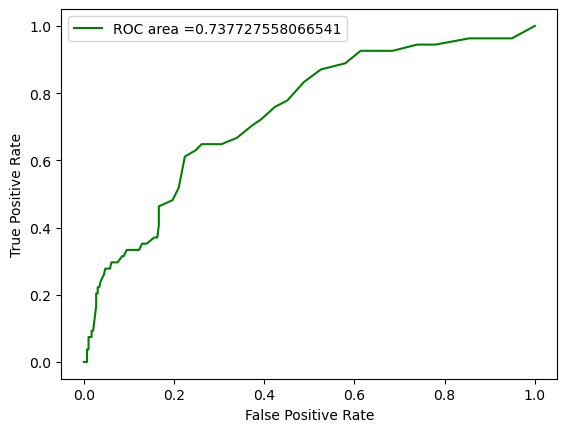

confusion_matrix
 [[286   9]
 [ 43  11]]


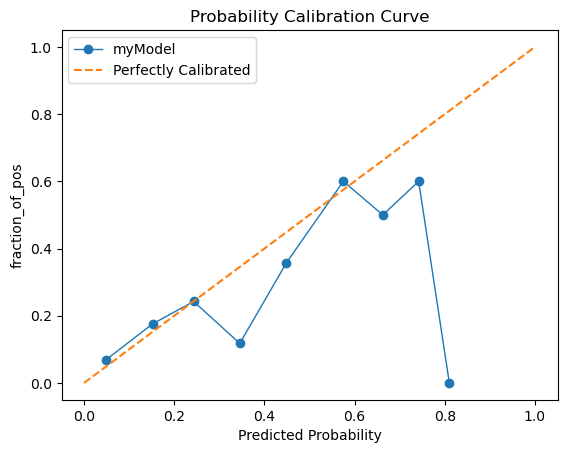

In [10]:
# ROC curve (4%), confusion matrix (3%), calibration plot 
from sklearn import metrics
# ROC curve 
print("ROC curve")
fpr, tpr, thershold = metrics.roc_curve(test_y, decisionTreeModel.predict_proba(test_X)[:, 1])
roc_auc = metrics.auc(fpr, tpr) # auroc
print("roc_auc", roc_auc)
plt.plot(fpr, tpr, label='ROC area ='+str(roc_auc), color='g')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()
# confusion matrix 
confusion_matrix = metrics.confusion_matrix(test_y, predicted_test_y)
print("confusion_matrix\n", confusion_matrix)
# calibration plot
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
predict_proba_pos = decisionTreeModel.predict_proba(test_X)[:, 1]
#print()
# True and Predicted Probabilities
fraction_of_pos, mean_predict_value = calibration_curve(test_y, predict_proba_pos, n_bins=10)
#print(fraction_of_pos, mean_predict_value)
#Plot the Probabilities Calibrated curve
plt.plot(mean_predict_value,
         fraction_of_pos, 
         marker='o', 
         linewidth=1, 
         label='myModel')
 
#Plot the Perfectly Calibrated by Adding the 45-degree line to the plot
plt.plot([0, 1], 
         [0, 1], 
         linestyle='--', 
         label='Perfectly Calibrated')
 
 
# Set the title and axis labels for the plot
plt.title('Probability Calibration Curve')
plt.xlabel('Predicted Probability')
plt.ylabel('fraction_of_pos')
 
# Add a legend to the plot
plt.legend(loc='best')


Text(0.5, 0, 'Feature Importance')

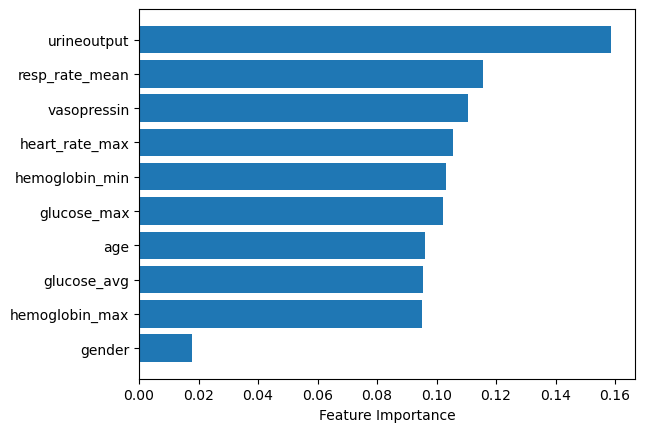

In [9]:
# Feature importance #correct!
# sort the feature importance from highest to lowest
sorted_idx = decisionTreeModel.feature_importances_.argsort() #[::-1]
sorted_feature = train_X.columns[sorted_idx]
sorted_importance = decisionTreeModel.feature_importances_[sorted_idx]
plt.barh(sorted_feature, sorted_importance)
plt.xlabel("Feature Importance")

In [7]:
# Fairness analysis (report AUC scores in different race groups) 

from sklearn.metrics import roc_auc_score

# find the race in stayid_race_in_icu_in_mimiciv.csv
df_race = pd.read_csv('stayid_race_in_icu_in_mimiciv.csv')
df3 = pd.merge(test_X_for_race, df_race, on=['stay_id'], how='inner')
df3 = pd.merge(df3, test_y_for_race, on=['stay_id'], how='inner')
# find the race type in df3 -> df3['race'].drop_duplicates()
df3 = df3.drop(columns=['stay_id'])

df3_Black = df3.loc[df3['race'].str.contains('BLACK')]
df3_White = df3.loc[df3['race'].str.contains('WHITE')]
df3_Asian = df3.loc[df3['race'].str.contains('ASIAN')]
df3_Hispanic = df3.loc[df3['race'].str.contains('HISPANIC')]
df3_Others = df3.loc[~df3['race'].str.contains('BLACK|WHITE|ASIAN|HISPANIC')]
# drop column race
df3_Black = df3_Black.drop(columns='race')
df3_White = df3_White.drop(columns='race')
df3_Asian = df3_Asian.drop(columns='race')
df3_Hispanic = df3_Hispanic.drop(columns='race')
df3_Others = df3_Others.drop(columns='race')

# compute AUC score
print("test: AUC score")
print("BLACK:", roc_auc_score(df3_Black['label'], decisionTreeModel.predict_proba(df3_Black.drop(columns='label'))[:, 1]))
print("WHITE:", roc_auc_score(df3_White['label'], decisionTreeModel.predict_proba(df3_White.drop(columns='label'))[:, 1]))
print("ASIAN:", roc_auc_score(df3_Asian['label'], decisionTreeModel.predict_proba(df3_Asian.drop(columns='label'))[:, 1]))
print("HISPANIC:", roc_auc_score(df3_Hispanic['label'], decisionTreeModel.predict_proba(df3_Hispanic.drop(columns='label'))[:, 1]))
print("OTHERS:", roc_auc_score(df3_Others['label'], decisionTreeModel.predict_proba(df3_Others.drop(columns='label'))[:, 1]))

test: AUC score
BLACK: 0.6681547619047619
WHITE: 0.7455995599559956
ASIAN: 0.8333333333333334
HISPANIC: 0.8888888888888888
OTHERS: 0.7829861111111112
